In [2]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Self-Attention GAN(SAGAN)
---
## 기존 GAN의 문제점
> GAN의 G는 전치합성곱을 반복하여 특징량 맵이 커지지만 전치합성곱에는 어떻게 해도 국소적인 정보의 확대밖에 되지 않는다는 문제가 있다. 
> 새롭게 생성되는 특징량 맵의 좌측 상단은 ConvTranspose2d에 대한 입력 데이터의 좌측 상단을 강하게 반영 한 것
>
> 전치 합성곱 ConvTranspose2d의 반복은 국소적 정보 확대의 연속이기 때문에, 더 좋은 화상 생성을 실현하기
위해서는 화상 전체의 포괄적 정보를 고려할 수 있는 구조를 만들어야 한다.
## Self-Attention
> 여기서 G는 4개의 레이어와 라스트, 총 5개 레이어로 생성 화상을 서서히 확대
> 중간 레이어 사이 출력을 𝑥로 함. 텐서 크기는 채널 수x높이x폭(CxHXW로 기술)
> 입력 변수 𝑥를 행렬 연산하기 쉽도록 cxHxW부터 CxN의 C행 N열로 변형. N은 WxH
> 변형한 𝑥끼리의 곱셈인 

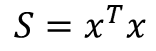
>를 생성

> S는 NxC의 행렬 𝑥^𝑇와 CxN 행렬 𝑥의 곱셈이므로 NxN 크기가 됨. 행렬 S의 요소 𝑠𝑖𝑗는 화상위치 i가 화상위치 j와 얼마나 비슷한지 나타냄.
> 화상 위치는 0에서 N-1까지로 나타남. 해당 위치 정보의 각 채널과 다른 위치 정보의 같은 채널 값을 곱하여 채널마다 구한 곱셈의 합도 계산함. 따라서 동일한 위치끼리 채널별로 값이 비슷하면 S𝑖𝑗는 큰 값이 됨. S𝑖𝑗는 화상위치의 특징량과 화상위치의 특징량의 닮은 정도를 나타냄
> 계속해서 S를 규격화함. 행 방향으로 소프트맥스 함수를 계산하여, 각 화상 위치가 화상 위치 j와 비슷한 정도의 총합을 1로 한 뒤 전치함. 이렇게 규격화 한 행렬을 𝛽로 함.

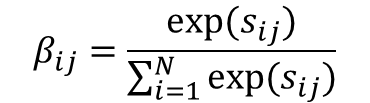

> 행렬 𝛽의 요소 𝛽𝑖𝑗는 위치 j의 특징량이 위치 i의 특징량과 얼마나 비슷한지 나타냄. 위치 j를 생성할 때 위치 i를 어느정도 고려해야 하는지 나타낸 것임. 앞선 규격화로 위치 i가 고려되는 양은 합계 1. 이렇게 만든 𝛽가 Attention Map이다.

> 마지막으로 CxN의 행렬과 Attention Map을 곱하면 현재 𝑥에 대응하고 𝑥를 포괄적인 정보로 조정하는 양인 Self-Attention Map의 o가 계산됨.

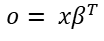


In [3]:
# 최초의 크기 변형 B, C, W, H-->B , C, N으로
X = X.view(X.shape[0], X.shape[1], X.shape[2]*X.shape[3]) # 크기 : B, C, N

# 곱셈
X_T =x.permute(0, 2, 1) # B, N, C 전치
S = torch.bmm(X_T, X) # bmm은 배치별 행렬곱

# 규격화
m = nn.Softmax(dim=-2) # i행 방향의 합을 1로 하는 소프트맥스 함수
attention_map_T = m(S) # 전치된 Attention Map
attention_map = attention_map_T.permute(0, 2, 1) # 전치를 취함

# self-attention 맵을 계산
o = torch.bmm(X, attention_map.permute(0, 2, 1)) # Attention Map은 전치하여 곱한다.

NameError: name 'X' is not defined

- Self-Attenton은 전치 합성곱에서 국소 정보만 고려하는 문제가 있어 등장했다. 국소 정보만 취하는 이유는 커널 크기를 작게 규정하기 때문인데, 커널 크기가 작아 작은 범위만 볼 수 있어 국소적인 정보만 얻을 수 있음
- 거대한 크기의 커널을 준비하면 좋을 것이라고 생각할 수 있으나, 계산 비용이 너무 높아져 학습이 잘 되지 않는다. 
- 계산 비용을 억제하기 위해서 제한을 두고 포괄적인 정보를 고려하는 구조가 필요했다.
--> 이러한 입력 데이터의 위치 정보 전체에 커널과 같은 기능을 가지면서도 제한을 주고 계산 비용을 절감하는 수단이 바로 `Self-Attention` 기법이다. 
> Self-Attention은 계산 비용을 억제하기 위하여 입력 데이터의 어떠한 셀의 특징량을 계산할 때, "주목할 셀은 자신과 비슷한 값의 셀로 한다"는 제한을 둔다.
> 이는 커널 크기 N 의 일반적인 합성곱이나 전치 합성곱의 경우에서 "입력 데이터의 어떠한 셀의 특징량을 계산할 때 주목할 셀은 주변 NxN 범위의 셀로 한다"는 표현에 대응한다.
>
> Self-Attention에서는 특징량을 계산할 대상 셀과 특징량이 비슷한 셀이 주목할 셀이다. // (합성곱이나 전치 합성곱에서는 계산할 대상 셀의 커널 크기 범위 주변 셀로 함)
> Self-Attention에 값 제한이 있어도 포괄적 정보를 고려한 특징량을 입력 데이터 x로 계산할 수 있도록, 입력 데이터 x를 한 번 특징량 변환한 후 Self-Attention에 전달한다.

### 1x1 합성곱(점별 합성곱)
- Self-Attention을 수행할 때 레이어의 출력 𝑥를 그대로 Self-Attention 계산에 사용하지 않고, 일단 특징량 변환하여 전달함
- 특징량 변환 방법으로 커널 크기가 1x1인 합성곱 층에서 𝑥를 크기 CxHxW에서 크기 C'xHxW로 변환하여 Self-Attention으로 사용함. 1x1의 합성곱 층이 점별 합성곱임.
- 커널 1의 합성곱 처리란 커널 크기가 1이므로, 합성곱 층에서 출력되는 결과는 입력하는 𝑥의 각 채널을 더한다는 것을 의미함.
- 점별 합성곱은 입력 데이터의 각 채널별 선형 합을 만드는 것으로, 1x1의 합성곱 층의 출력채널 수를 변화시켜 원래 입력 𝑥의 채널 수를 C에서 C'로 변화시킴. 기본적으로 출력 채널 수 C'는 입력 채널 수 C보다 작은 값임
- 원래 입력 𝑥의 특징량별 선형 합을 계산하는 작업, 즉 입력의 차원 압축을 진행함. 신경망의 오차 역전파에 원래 입력 𝑥의 채널 수 C에서 C'로 압축할 때 𝑥의 정보가 누락되기 어려운 선형 합의 계수(점별 합성곱의 커널 가중치)를 학습해 줌

In [ ]:
# 1x1 합성곱층을 활용한 점별 합성곱과 Self-Attention을 구현하면 다음과 같음
query_conv = nn.Conv2d(in_channels=X.shape[1], out_channels=X.shape[1] // 8,
                        kernel_size = 1)
key_conv = nn.Conv2d(in_channels=X.shape[1], out_channels=X.shape[1]//8, 
                     kernel_size =1)
value_conv = nn.Conv2d(in_channels=X.shape[1], out_channels=X.shape[1],
                      kernel_size=1)

# 합성곱한 뒤 크기를 변형시킨다. B, C', W, H --> B, C', N
proj_query = query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3]) 
proj_query = proj_query.permute(0, 2, 1) # 전치 조작
proj_key = key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])

# 곱셈
S = torch.bmm(proj_query, proj_key) # bmm은 배치별 행렬곱

# 규격화
m = nn.Softmax(dim=-2) # i행 방향의 합을 1로 하는 소프트맥스 함수
attention_map_T = m(S) # 전치된 Attention Map
attention_map = attention_map_T.permute(0, 2, 1) # 전치를 취한다

# Self-Attention Map 계산
proj_value = value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3]) # 크기 : B, C, N
# Attention Map을 전치하여 곱함
o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))

---

## 스펙트럴 정규화
- SAGAN에서는 스펙트럴 정규화라는 개념으로 합성곱 층의 가중치를 규격화함.
파이토치로 구현하면 torch.nn.utils.spectral_norm()

> GAN이 잘 작동하려면 식별기 D가 `립시츠 연속성(lipschitz continuity)`을 가져야 함. 립시츠 연속성이란, '식별기 D의 입력 화상이 
아주 조금 변하면 식별기 D의 출력은 거의 변하지 않는다'는 뜻이다. 반대로 립시츠 연속성이 확보되지 않은 식별기는 식별기 D의 입력
화상이 아주 조금만 변해도 식별기 D의 출력이 크게 변함. 이는 G와 D가 제대로 학습하지 못한다는 느낌임.

> D의 네트워크가 립시츠 연속성을 보유하려면, 스펙트럴 정규화에서 가중치를 정규화하는 작업을 실행하는 것이다. 

## Self-Attention 모듈 구현
- 모듈에 대한 입력이 𝑥, Self-Attention Map이 o일 때 출력은 다음과 같다
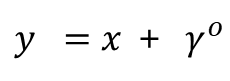
- 𝛾은 적당한 계수이며 초깃값 0부터 학습시킴. 구현 시 nn.Parameter()를 사용하여 변수를 생성

In [36]:
class Self_Attention(nn.Module) :
    '''Self-Attention layer'''
    
    def __init__(self, in_dim) :
        super(Self_Attention, self).__init__()
        
        # 1x1의 합성곱 층을 활용한 점별 합성곱 준비
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8,
                                   kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8,
                                 kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim,
                                   kernel_size=1)
        
        # Attention Map을 작성할 때 규격화 소프트맥스
        self.softmax = nn.Softmax(dim=-2)
        
        # 원래 입력 x와 Self-Attention Map인 o를 더할 때 계수
        # output = x + gamma * o
        # 처음에는 gamma=0으로 학습시킨다.
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x) :
        
        # 입력 변수
        X = x
        
        # 합성곱한 뒤 크기를 변형시킴. B, C', W, H->B, C', N으로
        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3]) # 크기 : B, C', N
        proj_query = proj_query.permute(0, 2, 1) # 전치 조작
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3]) # 크기 : B, C', N
        
        # 곱셈
        S = torch.bmm(proj_query, proj_key) # bmm은 배치별 행렬곱
        
        # 규격화
        attention_map_T = self.softmax(S) # i행 방향의 합을 1로 하는 소프트맥스 함수
        attention_map = attention_map_T.permute(0, 2, 1) # 전치
        
        # Self-Attention Map 계산
        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1)) # Attention Map을 전치하여 곱함
        
        # Self-Attention Map의 텐서 크기를 X로 준비하여 출력
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma * o
        
        return out, attention_map


## Generator 구현
- 전치합성곱 층에 스펙트럴 정규화 추가(last의 전치 합성곱 층에는 추가하지 않음)
- layer 3과 layer 4의 사이 / layer 4와 last 사이 두 군데에 Self-Attention 모듈 추가

In [43]:
class Generator(nn.Module) :
    
    def __init__(self, z_dim=20, image_size=64) :
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size*8,
                                                 kernel_size=4, stride=1)),
        nn.BatchNorm2d(image_size*8),
        nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*8,
                                image_size*4, kernel_size=4, stride=2,
                                                 padding=1)),
                                nn.BatchNorm2d(image_size*4),
                                nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*4, image_size*2,
                                kernel_size=4, stride=2, padding=1)),
        
        nn.BatchNorm2d(image_size*2),
        nn.ReLU(inplace=True))
        
        # Self-Attention 층 추가
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        self.layer4 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size*2, image_size,
                                kernel_size=4, stride=2, padding=1)),
        nn.BatchNorm2d(image_size),
        nn.ReLU(inplace=True))
        
        # Sself-Attention 층 추가
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        self.last = nn.Sequential(nn.ConvTranspose2d(image_size,
                                1, kernel_size=4, stride=2, padding=1),
                                 nn.Tanh())
        # 주의 ! 흑백 화상이므로 출력 채널은 하나 뿐이다
        
    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)        
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2


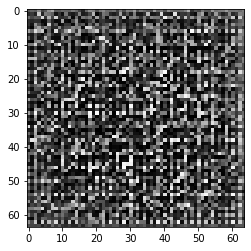

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

## Discriminator 구현
- 전치합성곱 층에 스펙트럴 정규화 추가(last의 전치 합성곱 층에는 추가하지 않음)
- layer 3과 layer 4의 사이 / layer 4와 last 사이 두 군데에 Self-Attention 모듈 추가

In [45]:
class Discriminator(nn.Module) :
    
    def __init__(self, z_dim=20, image_size=64) :
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
                    #스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4,
                                                   stride=2, padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
                    # 흑백 화상이므로 출력 채널은 하나뿐이다.
            
        self.layer2 = nn.Sequential(
                    # 스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, 
                                                    kernel_size=4, stride=2,
                                                    padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
                    # 스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, 
                                                    kernel_size=4, stride=2,
                                                    padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
            
        # Self-Attention 층 추가
        self.self_attention1 = Self_Attention(in_dim = image_size * 4)
        
        self.layer4= nn.Sequential(
                    # 스펙트럴 정규화 추가
                    nn.utils.spectral_norm(nn.Conv2d(image_size * 4, image_size * 8,
                                                    kernel_size=4, stride=2, padding=1)),
                    nn.LeakyReLU(0.1, inplace=True))
         
        
        # Self-Attention 층 추가
        self.self_attention2 = Self_Attention(in_dim=image_size*8)
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
            
    
    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)            
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2

In [46]:

D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

d_out, attention_map1, attention_map2 = D(fake_images)

print(nn.Sigmoid()(d_out))

tensor([[[[0.5065]]]], grad_fn=<SigmoidBackward>)


In [39]:
def make_datapath_list() :
    '''학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성'''
    
    train_img_list = list() # 화상 파일 경로 저장
    
    for img_idx in range(200) :
        img_path = './pytorch_advanced/gan_generation/data/img_78/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './pytorch_advanced/gan_generation/data/img_78/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform() :
    '''화상 전처리 클래스'''
    
    def __init__(self, mean, std) :
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
    def __call__(self, img) :
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset) :
    '''화상의 데이터셋 클래스, 파이토치의 데이터셋 클래스를 상속'''
    
    def __init__(self, file_list, transform) :
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self) :
        '''화상 매수 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index) :
        '''전처리 화상의 텐서 형식 데이터 취득'''
        
        img_path = self.file_list[index]
        img = Image.open(img_path) # [높이][폭]
        
        # 화상 전처리
        img_transformed = self.transform(img)
        
        return img_transformed
    
    # 데이터 로더 작성과 동작 확인

    
# 파일 리스트 작성
train_img_list = make_datapath_list()

# 데이터셋 작성
mean = (0.5, )
std = (0.5, )

train_dataset = GAN_Img_Dataset(file_list=train_img_list,
                               transform=ImageTransform(mean, std))

# 데이터 로더 작성
batch_size=  64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
# 동작 확인
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 첫 번째 요소를 꺼냄
print(images.size()) # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 64, 64])


## 네트워크 초기화와 학습

### Discriminator
- SAGAN에서는 손실함수를 `적대적 손실의 힌지 버전`으로 불리는 것으로 변경함.

In [10]:
# DCGAN에서 식별기 D의 손실함수
criterion = nn.BCEWithLogitsLoss(reduction='mean')
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

NameError: name 'd_out_real' is not defined

- SAGAN의 적대적 손실 힌지 버전 D의 손실함수
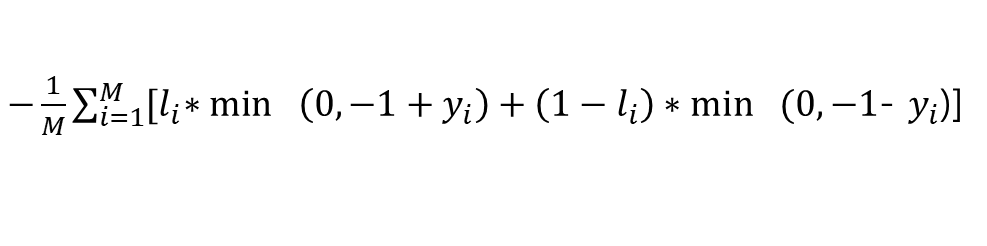

In [ ]:
# SAGAN의 D 손실함수
d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()

### Generator

In [ ]:
# DCGAN에서 G의 손실함수
criterion = nn.BCEWithLogitsLoss(reduction='mean')
g_loss = criterion(d_out_fake.view(-1), label_real)

- SAGAN의 적대적 손실 힌지 버전 G의 손실함수
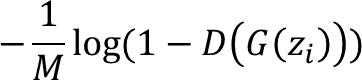

In [ ]:
# SAGAN의 G 손실함수
g_loss = -d_out_fake.mean()

> 힌지 버전의 손실함수를 사용하는 이유는, GAN의 일반 손실함수보다 경험적으로 잘 학습할 수 있기 때문

In [50]:
# SAGAN의 학습 함수 구현

# 모델을 학습시키는 함수 작성
def train_model(G, D, dataloader, num_epochs) :
    
    # GPU 사용 여부 확인
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('사용 장치 :', device)
    
    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # 오차함수 정의 -> 적대적 손실의 힌지 버전으로 변경
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # 파라미터 하드코딩
    z_dim = 20
    mini_batch_size=64
    
    # 네트워크를 GPU로
    G.to(device)
    D.to(device)
    
    G.train() # 모델을 훈련 모드로
    D.train() # 모델을 훈련 모드로
    
    # 네트워크가 어느 정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 화상 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # 반복 카운터 설정
    iteration = 1
    logs = []
    
    # 에폭 루프
    for epoch in range(num_epochs) :
        
        # 개시 시간 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0 # 에폭의 손실 합
        epoch_d_loss = 0.0 # 에폭의 손실 합
        
        print('-' * 20)
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 20)
        print(' (train) ')
        
        # 데이터 로더에서 미니배치 씩 꺼내는 루프
        for images in dataloader :
            
            # ------------------------
            # 1. discriminator 학습
            # ------------------------
            # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하므로 피한다
            if images.size()[0] == 1 :
                continue
                
            # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다
            images= images.to(device)
            
            # 정답 라벨과 가짜 라벨 작성
            # 에폭의 마지막 반복은 미니배치 수가 줄어듦
            mini_batch_size = images.size()[0]
            # label_real = torch.full((mini_batch_size,), 1).to(device)
            # label_fake = torch.full((mini_batch_size,), 0).to(device)    
            
            # 진짜 화상 판정
            d_out_real, _, _ = D(images)
            
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size , z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 오차 계산 --> 적대적 손실의 힌지 버전으로 변경
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 오차 d_out_real이 1 이상에서 오차 0이 된다. d_out_real > 1에서
            # 1.0 - d_out_real이 음수이면 ReLU 로 0으로 한다.
            
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake < -1에서
            # 1.0 + dout_real이 음수이면 ReLU로 0으로 한다.
            
            d_loss = d_loss_real + d_loss_fake
            
            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            # ------------------------
            # 2. Generator 학습
            # ------------------------
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 오차 계산 --> 적대적 손실의 힌지 버전으로 변경
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = -d_out_fake.mean()
            
            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # ------------------------
            # 3. 기록
            # ------------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # 에폭의 phase 별 손실과 정답률
        t_epoch_finish = time.time()
        print('-' * 20)
        print(f'epoch {epoch} || epoch_D_Loss : {epoch_d_loss/batch_size:.4f} || Epoch_G_Loss : {epoch_g_loss/batch_size:.4f}')
        print(f'timer: {t_epoch_finish  - t_epoch_start:.4f}')
        t_epoch_start = time.time()
              
    return G, D

In [51]:
# 네트워크 초기화
def weights_init(m) :
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        # Conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constatn_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 :
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data ,1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    # 초기화 실시
    G.apply(weights_init)
    D.apply(weights_init)
    
    print('네트워크 초기화 완료')
    
# 학습 및 검증 실행
num_epochs = 300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

사용 장치 : cpu
--------------------
Epoch 0/300
--------------------
 (train) 
--------------------
epoch 0 || epoch_D_Loss : 0.1703 || Epoch_G_Loss : 0.0303
timer: 32.3522
--------------------
Epoch 1/300
--------------------
 (train) 
--------------------
epoch 1 || epoch_D_Loss : 0.1330 || Epoch_G_Loss : 0.0814
timer: 32.0080
--------------------
Epoch 2/300
--------------------
 (train) 
--------------------
epoch 2 || epoch_D_Loss : 0.1278 || Epoch_G_Loss : 0.0788
timer: 31.9667
--------------------
Epoch 3/300
--------------------
 (train) 
--------------------
epoch 3 || epoch_D_Loss : 0.1323 || Epoch_G_Loss : 0.0685
timer: 32.2571
--------------------
Epoch 4/300
--------------------
 (train) 
--------------------
epoch 4 || epoch_D_Loss : 0.1422 || Epoch_G_Loss : 0.0122
timer: 32.5131
--------------------
Epoch 5/300
--------------------
 (train) 
--------------------
epoch 5 || epoch_D_Loss : 0.1780 || Epoch_G_Loss : 0.0244
timer: 31.9513
--------------------
Epoch 6/300
-------

--------------------
epoch 51 || epoch_D_Loss : 0.1657 || Epoch_G_Loss : 0.0609
timer: 31.0639
--------------------
Epoch 52/300
--------------------
 (train) 
--------------------
epoch 52 || epoch_D_Loss : 0.1641 || Epoch_G_Loss : 0.0404
timer: 30.9123
--------------------
Epoch 53/300
--------------------
 (train) 
--------------------
epoch 53 || epoch_D_Loss : 0.1555 || Epoch_G_Loss : 0.0534
timer: 31.0829
--------------------
Epoch 54/300
--------------------
 (train) 
--------------------
epoch 54 || epoch_D_Loss : 0.1717 || Epoch_G_Loss : 0.0433
timer: 31.1786
--------------------
Epoch 55/300
--------------------
 (train) 
--------------------
epoch 55 || epoch_D_Loss : 0.1576 || Epoch_G_Loss : 0.0853
timer: 31.1098
--------------------
Epoch 56/300
--------------------
 (train) 
--------------------
epoch 56 || epoch_D_Loss : 0.1623 || Epoch_G_Loss : 0.0510
timer: 31.2006
--------------------
Epoch 57/300
--------------------
 (train) 
--------------------
epoch 57 || epoch_D

--------------------
epoch 103 || epoch_D_Loss : 0.1307 || Epoch_G_Loss : 0.0833
timer: 31.1666
--------------------
Epoch 104/300
--------------------
 (train) 
--------------------
epoch 104 || epoch_D_Loss : 0.1214 || Epoch_G_Loss : 0.0621
timer: 31.2833
--------------------
Epoch 105/300
--------------------
 (train) 
--------------------
epoch 105 || epoch_D_Loss : 0.1307 || Epoch_G_Loss : 0.0740
timer: 31.2644
--------------------
Epoch 106/300
--------------------
 (train) 
--------------------
epoch 106 || epoch_D_Loss : 0.1228 || Epoch_G_Loss : 0.0730
timer: 31.3731
--------------------
Epoch 107/300
--------------------
 (train) 
--------------------
epoch 107 || epoch_D_Loss : 0.1231 || Epoch_G_Loss : 0.0920
timer: 30.9712
--------------------
Epoch 108/300
--------------------
 (train) 
--------------------
epoch 108 || epoch_D_Loss : 0.1306 || Epoch_G_Loss : 0.0894
timer: 31.1218
--------------------
Epoch 109/300
--------------------
 (train) 
--------------------
epoch 1

--------------------
epoch 154 || epoch_D_Loss : 0.0696 || Epoch_G_Loss : 0.1308
timer: 31.2704
--------------------
Epoch 155/300
--------------------
 (train) 
--------------------
epoch 155 || epoch_D_Loss : 0.0628 || Epoch_G_Loss : 0.1559
timer: 31.0001
--------------------
Epoch 156/300
--------------------
 (train) 
--------------------
epoch 156 || epoch_D_Loss : 0.0789 || Epoch_G_Loss : 0.1447
timer: 30.8674
--------------------
Epoch 157/300
--------------------
 (train) 
--------------------
epoch 157 || epoch_D_Loss : 0.0898 || Epoch_G_Loss : 0.1404
timer: 31.1786
--------------------
Epoch 158/300
--------------------
 (train) 
--------------------
epoch 158 || epoch_D_Loss : 0.0522 || Epoch_G_Loss : 0.1736
timer: 31.2853
--------------------
Epoch 159/300
--------------------
 (train) 
--------------------
epoch 159 || epoch_D_Loss : 0.0858 || Epoch_G_Loss : 0.1159
timer: 31.1527
--------------------
Epoch 160/300
--------------------
 (train) 
--------------------
epoch 1

--------------------
epoch 205 || epoch_D_Loss : 0.0348 || Epoch_G_Loss : 0.2008
timer: 30.9881
--------------------
Epoch 206/300
--------------------
 (train) 
--------------------
epoch 206 || epoch_D_Loss : 0.0535 || Epoch_G_Loss : 0.2017
timer: 31.1676
--------------------
Epoch 207/300
--------------------
 (train) 
--------------------
epoch 207 || epoch_D_Loss : 0.0259 || Epoch_G_Loss : 0.1861
timer: 30.9542
--------------------
Epoch 208/300
--------------------
 (train) 
--------------------
epoch 208 || epoch_D_Loss : 0.0645 || Epoch_G_Loss : 0.1902
timer: 31.1248
--------------------
Epoch 209/300
--------------------
 (train) 
--------------------
epoch 209 || epoch_D_Loss : 0.0277 || Epoch_G_Loss : 0.2129
timer: 30.9502
--------------------
Epoch 210/300
--------------------
 (train) 
--------------------
epoch 210 || epoch_D_Loss : 0.0433 || Epoch_G_Loss : 0.1746
timer: 30.9772
--------------------
Epoch 211/300
--------------------
 (train) 
--------------------
epoch 2

--------------------
epoch 256 || epoch_D_Loss : 0.0279 || Epoch_G_Loss : 0.2588
timer: 30.8984
--------------------
Epoch 257/300
--------------------
 (train) 
--------------------
epoch 257 || epoch_D_Loss : 0.0175 || Epoch_G_Loss : 0.2390
timer: 31.0490
--------------------
Epoch 258/300
--------------------
 (train) 
--------------------
epoch 258 || epoch_D_Loss : 0.0251 || Epoch_G_Loss : 0.2408
timer: 31.1517
--------------------
Epoch 259/300
--------------------
 (train) 
--------------------
epoch 259 || epoch_D_Loss : 0.0214 || Epoch_G_Loss : 0.2486
timer: 31.2395
--------------------
Epoch 260/300
--------------------
 (train) 
--------------------
epoch 260 || epoch_D_Loss : 0.0218 || Epoch_G_Loss : 0.2404
timer: 30.8036
--------------------
Epoch 261/300
--------------------
 (train) 
--------------------
epoch 261 || epoch_D_Loss : 0.0298 || Epoch_G_Loss : 0.2106
timer: 31.2085
--------------------
Epoch 262/300
--------------------
 (train) 
--------------------
epoch 2

### 학습 결과 시각화

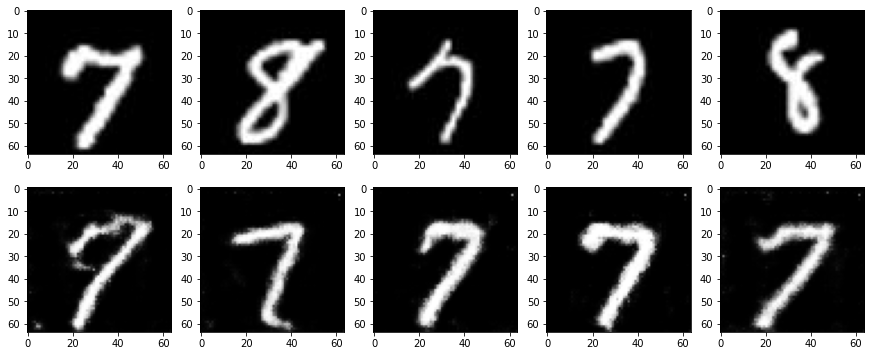

In [52]:
# 생성 화상과 훈련 데이터 시각화
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지 몇 번 재실행한다.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 첫 번째 요소를 꺼냄

# 출력
fig = plt.figure(figsize=(15, 6))

for i in range(0, 5) :
    # 상단에 훈련 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 하단에 생성 데이터 표시
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

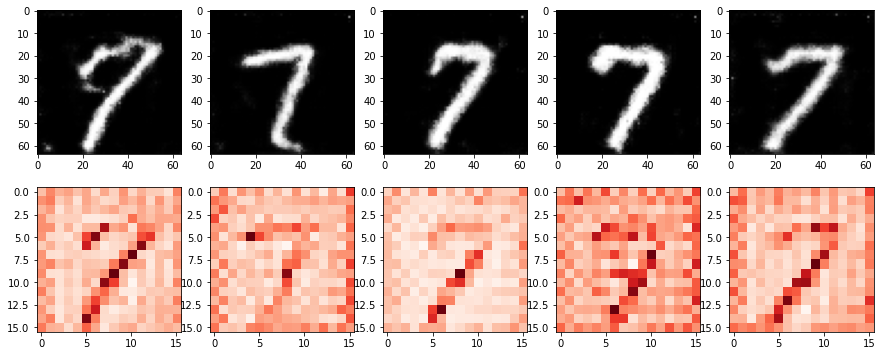

In [54]:
# Attention Map 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5) :
    
    # 하단에 생성한 화상 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    
    # 하단에 Attention Map 1 화상 중앙의 픽셀 데이터 표시
    plt.subplot(2, 5, 5+i+1) 
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7] # 중앙에 주목
    plt.imshow(am.cpu().detach().numpy(), 'Reds')